# **Step 1: Loading Libraries and  Exploring Dataset**


Dataset Head:
                                           Statement      Status
0  life doesn’t feel worth it that’s kind of it? ...  Depression
1  This life sucks and if it were for my religiou...  Depression
2  its been 9 months now for our marriage and she...      Stress
3  I do not feel particularly sad or anxious or a...  Depression
4  I am taking Venlafaxine. it is an SSRI. does n...  Depression

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37130 entries, 0 to 37129
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  36876 non-null  object
 1   Status     37130 non-null  object
dtypes: object(2)
memory usage: 580.3+ KB
None

Missing Values:
Statement    254
Status         0
dtype: int64
Missing Values Per Class:
                      Statement  Status
Status                                 
Anxiety                      30       0
Bipolar                      73       0
Depression          

<ipython-input-7-40c48f6010ac>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_values_per_class = df.groupby("Status").apply(lambda x: x.isnull().sum())


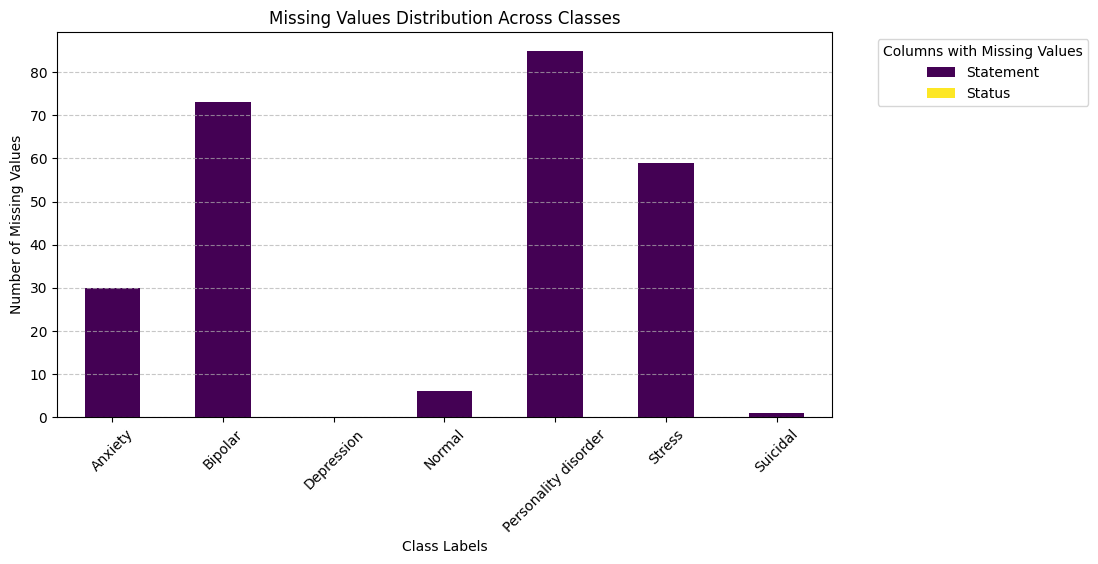

Number of Instances Per Class:
Status
Normal                  11446
Depression              10783
Suicidal                 7457
Anxiety                  2721
Bipolar                  2014
Stress                   1868
Personality disorder      841
Name: count, dtype: int64


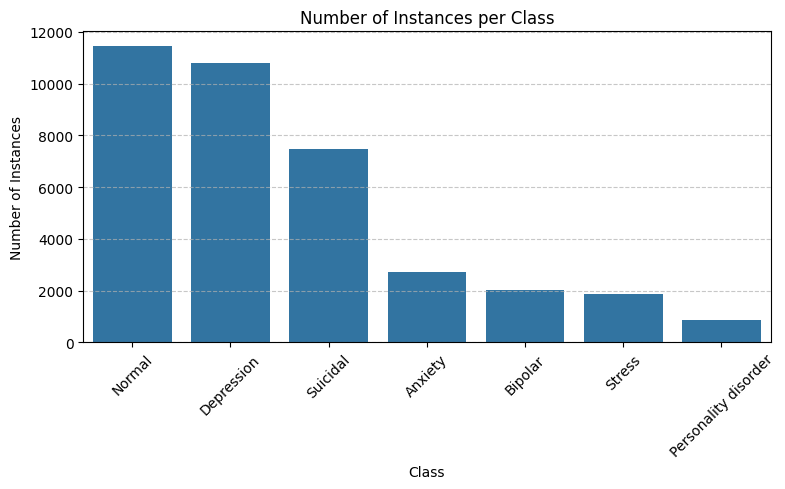

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Dataset
df = pd.read_csv("Sentiment_analysis_dataset.csv")
# Inspect Data
print("Dataset Head:")
print(df.head())
print("\nDataset Info:")
print(df.info())

# Check for Missing Values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for missing values per class
missing_values_per_class = df.groupby("Status").apply(lambda x: x.isnull().sum())

# Display missing values per class
print("Missing Values Per Class:")
print(missing_values_per_class)

# Plot Bar Graph
missing_values_per_class.plot(kind='bar', figsize=(10, 5), stacked=True, colormap='viridis')
plt.title("Missing Values Distribution Across Classes")
plt.xlabel("Class Labels")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45)
plt.legend(title="Columns with Missing Values", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Count instances per class
class_counts = df['Status'].value_counts()

# Print number of instances per class
print("Number of Instances Per Class:")
print(class_counts)

# Plot number of instances per class
plt.figure(figsize=(8,5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Number of Instances per Class")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Count instances per class
class_counts = df['Status'].value_counts()


# **Step 2: Data preprocessing and Baseline Performance**

Part 1: Cleaning the data


In [9]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# Drop rows with missing 'Statement'
before_drop = df.shape[0]
df.dropna(subset=['Statement'], inplace=True)
df.reset_index(drop=True, inplace=True)
after_drop = df.shape[0]
print(f"Rows before drop: {before_drop}")
print(f"Rows after drop: {after_drop}")
print(f"Total rows dropped: {before_drop - after_drop}")

# Download stopwords if not already downloaded
nltk.download('stopwords')
port_stem = PorterStemmer()

def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

df['Statement'] = df['Statement'].apply(stemming)
df.head()

Rows before drop: 36876
Rows after drop: 36876
Total rows dropped: 0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Statement,Status
0,life feel worth kind made lot discoveri last y...,Depression
1,life suck religi belief suicid send hell would...,Depression
2,month marriag manag sleep light cant even thin...,Stress
3,feel particularli sad anxiou anyth feel like w...,Depression
4,take venlafaxin ssri cure depress certainli ta...,Depression




Part 2: Solving the imbalance with different techniques then running logistic regression





[Baseline (No Balancing)] Accuracy: 0.7400
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.74      0.77       538
             Bipolar       0.93      0.61      0.73       388
          Depression       0.66      0.72      0.69      2157
              Normal       0.83      0.94      0.88      2288
Personality disorder       0.85      0.40      0.55       151
              Stress       0.72      0.36      0.48       362
            Suicidal       0.65      0.61      0.63      1492

            accuracy                           0.74      7376
           macro avg       0.78      0.63      0.68      7376
        weighted avg       0.74      0.74      0.73      7376



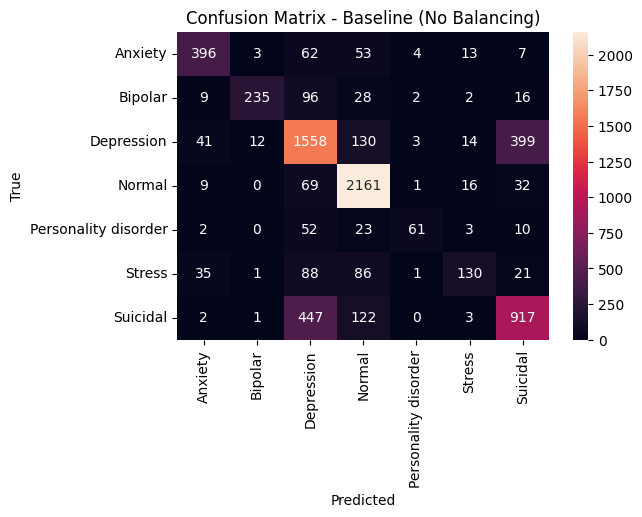


[Random Oversampling] Accuracy: 0.7321
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.71      0.79      0.75       538
             Bipolar       0.72      0.78      0.75       388
          Depression       0.74      0.58      0.65      2157
              Normal       0.88      0.91      0.90      2288
Personality disorder       0.42      0.67      0.52       151
              Stress       0.48      0.65      0.55       362
            Suicidal       0.64      0.67      0.65      1492

            accuracy                           0.73      7376
           macro avg       0.66      0.72      0.68      7376
        weighted avg       0.74      0.73      0.73      7376



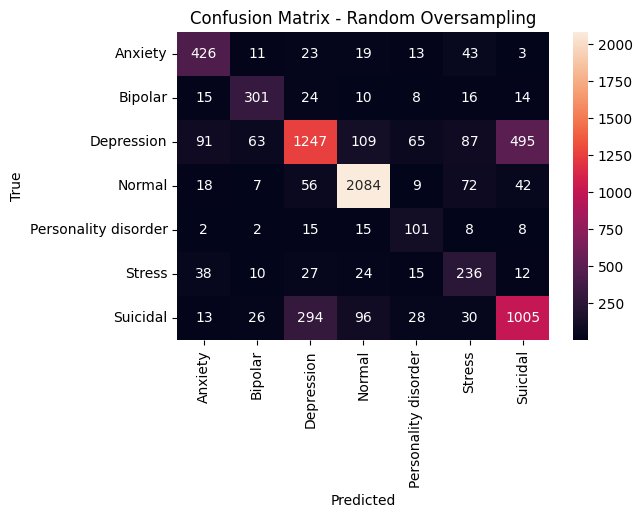


[Class Weight = 'balanced'] Accuracy: 0.7337
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.71      0.80      0.75       538
             Bipolar       0.72      0.77      0.75       388
          Depression       0.76      0.56      0.64      2157
              Normal       0.87      0.91      0.89      2288
Personality disorder       0.40      0.72      0.52       151
              Stress       0.47      0.68      0.56       362
            Suicidal       0.65      0.69      0.67      1492

            accuracy                           0.73      7376
           macro avg       0.66      0.73      0.68      7376
        weighted avg       0.75      0.73      0.73      7376



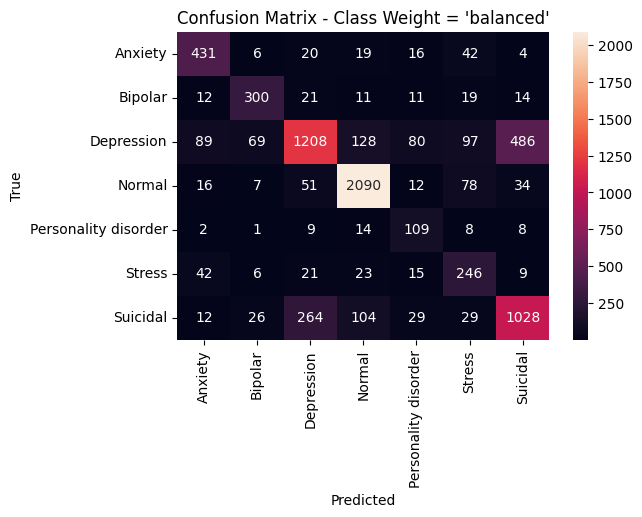

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

###############################################################################
# 1) DATA PREPARATION: LABEL ENCODING & TRAIN/TEST SPLIT
###############################################################################
# Encode the target variable
le = LabelEncoder()
df['label'] = le.fit_transform(df['Status'])

# Split the dataset into training and testing sets (using original imbalanced data)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['Statement'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

###############################################################################
# 2) TF-IDF VECTORIZATION (FIT ON TRAINING DATA ONLY)
###############################################################################
# Initialize TF-IDF Vectorizer with a maximum of 5000 features
tfidf = TfidfVectorizer(max_features=5000)

# Fit TF-IDF on the training text and transform both training and test text
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

###############################################################################
# 3) HELPER FUNCTION: EVALUATE MODEL
###############################################################################

def evaluate_model(model, X_test, y_test, approach_name):
    """
    Print Accuracy, Classification Report, and plot Confusion Matrix.
    """
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\n[{approach_name}] Accuracy: {acc:.4f}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {approach_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

###############################################################################
# 4) BASELINE: NO CLASS BALANCING
###############################################################################

# Train a Logistic Regression model on the training set without any balancing
model_baseline = LogisticRegression(max_iter=1000)
model_baseline.fit(X_train_tfidf, y_train)

# Evaluate the baseline model on the test set
evaluate_model(model_baseline, X_test_tfidf, y_test, "Baseline (No Balancing)")

###############################################################################
# 5) RANDOM OVERSAMPLING (APPLY ON TRAINING DATA ONLY)
###############################################################################

###############################################################################
# Apply Random Oversampling only on the training data for future use
###############################################################################
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_tfidf, y_train)

# Train the model on the oversampled training data
model_ros = LogisticRegression(max_iter=1000)
model_ros.fit(X_train_ros, y_train_ros)

# Evaluate the oversampled model on the original imbalanced test set
evaluate_model(model_ros, X_test_tfidf, y_test, "Random Oversampling")

###############################################################################
# 6) CLASS WEIGHT BALANCED
###############################################################################
# Train a Logistic Regression model using class_weight='balanced' on the training data
model_cw = LogisticRegression(max_iter=1000, class_weight='balanced')
model_cw.fit(X_train_tfidf, y_train)

# Evaluate the class weight balanced model on the test set
evaluate_model(model_cw, X_test_tfidf, y_test, "Class Weight = 'balanced'")

# **Step 3: Trying Random Forests**

=== RandomForest with Random Oversampling ===
Accuracy: 0.7291
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.74      0.77       538
             Bipolar       0.91      0.62      0.74       388
          Depression       0.62      0.71      0.66      2157
              Normal       0.83      0.95      0.89      2288
Personality disorder       0.98      0.43      0.60       151
              Stress       0.90      0.30      0.45       362
            Suicidal       0.64      0.59      0.61      1492

            accuracy                           0.73      7376
           macro avg       0.81      0.62      0.67      7376
        weighted avg       0.74      0.73      0.72      7376



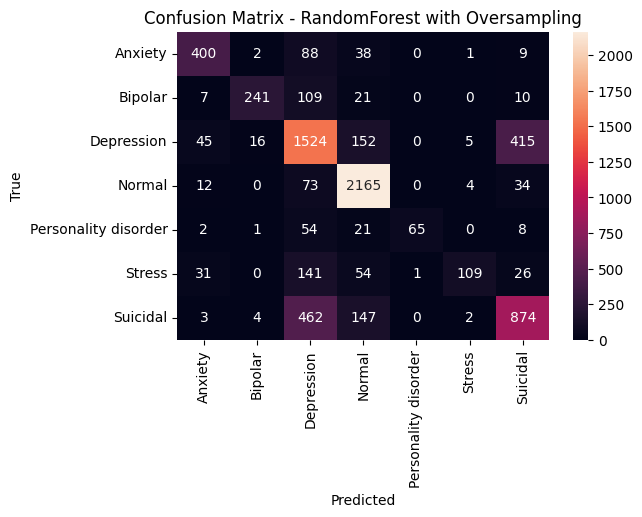


=== RandomForest with Class Weight 'balanced' ===
Accuracy: 0.7291
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.74      0.77       538
             Bipolar       0.91      0.62      0.74       388
          Depression       0.62      0.71      0.66      2157
              Normal       0.83      0.95      0.89      2288
Personality disorder       0.98      0.43      0.60       151
              Stress       0.90      0.30      0.45       362
            Suicidal       0.64      0.59      0.61      1492

            accuracy                           0.73      7376
           macro avg       0.81      0.62      0.67      7376
        weighted avg       0.74      0.73      0.72      7376



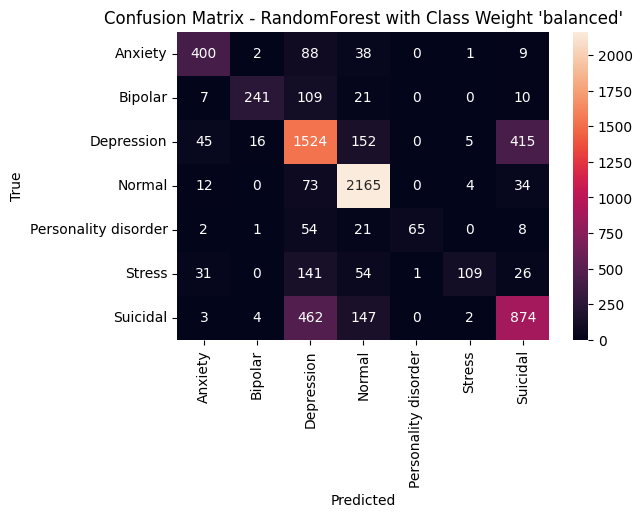

In [12]:
from sklearn.ensemble import RandomForestClassifier

#####################################
# Approach 1: Random Oversampling
#####################################

# Train Random Forest on the oversampled training data
rf_ros = RandomForestClassifier(random_state=42)
rf_ros.fit(X_train_ros, y_train_ros)

# Evaluate the model on the original (imbalanced) test set
y_pred_ros = rf_ros.predict(X_test_tfidf)
print("=== RandomForest with Random Oversampling ===")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_ros)))
print("Classification Report:")
print(classification_report(y_test, y_pred_ros, target_names=le.classes_))

# Plot confusion matrix for the oversampling approach
cm_ros = confusion_matrix(y_test, y_pred_ros)
plt.figure(figsize=(6,4))
sns.heatmap(cm_ros, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - RandomForest with Oversampling")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#####################################
# Approach 2: Class Weight Balanced Random Forest
#####################################

# Train Random Forest with class_weight='balanced'
rf_cw = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_cw.fit(X_train_ros, y_train_ros)

# Evaluate the model on the test set
y_pred_cw = rf_cw.predict(X_test_tfidf)
print("\n=== RandomForest with Class Weight 'balanced' ===")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred_cw)))
print("Classification Report:")
print(classification_report(y_test, y_pred_cw, target_names=le.classes_))

# Plot confusion matrix for the class weight approach
cm_cw = confusion_matrix(y_test, y_pred_cw)
plt.figure(figsize=(6,4))
sns.heatmap(cm_cw, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - RandomForest with Class Weight 'balanced'")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()